# Uterine fibroids follow-up treatment meta-analysis

Our goal is to estimate the probabilities of requiring one of a suite of candidate follow-up treatments following randomization to a given initial treatment for uterine fibroids. Specifically, we are interested in estimating:

$$Pr(I_2|I_1 =i,T=t)$$

where $I_1$ is an initial intervention, which take specific values $i = 1, 2, \ldots , K$ for each of $K$ candidate intervention types, $I_2$ is the followup intervention that also may take any of the same values of $i$, and $T$ is followup time in months, which will generally be either 6 or 12 months.

Our current set of candidate interventions include:

- Myomectomy
- Hysterectomy
- Ablation
- UAE
- Magnetic resonance imaging-guided high-intensity focused ultrasound (MRIgFUS) 
- Ablation +/- hysteroscopic myomectomy
- No intervention

Rather than model each conditional probability independently, we will instead model the outcomes for a treatment arm as a multinomial random variable. That is,

$$\{X_{I_2} \} ∼ \text{Multinomial}(N_{I_1}=i, \{\pi_i\})$$

where $\{X_{I_2}\}$ is the vector of outcomes corresponding to each of the possible followup interventions listed above, $N_{I_1}=i$ is the number of women randomized to the initial intervention i, and $\{\pi_i\}$ is a vector of conditional transition probabilities corresponding to $Pr(I_2|I_1 = i, T = t)$, as specified above. The multinomial distribution is a multivariate generalization of the categorical distribution, which is what the above simplifies to when modeling the outcome for a single patient. The multivariate formulation allows us to model study-arm-specific outcomes, incorporating covariates that are specific to that arm or study.
       
The quantities of interest are the vectors of transition probabilities $\{\pi_i\}$ corresponding to each of the initial candidate interventions. A naive approach to modeling these is to assign a vague Dirichlet prior distribution to each set, and perform Bayesian inference using the multinomial likelihood, with which the Dirichlet is conjugate, to yield posterior estimates for each probability. However, there may be additional information with which to model these probabilities, which may include:

- followup time for each study
- arm-specific demographic covariates (e.g. race, mean age) 
- study-specific random effects

hence, a given transition probability $\pi_{ijk}$ – the probability of transitioning from initial intervention $i$ to followup intervention $j$ in study $k$ – may be modeled as:

$$\text{logit}(\pi_{ijk})= \theta_{ij} + X_k \beta_{ij} + \epsilon_k$$

where $\theta_{ij}$ is a baseline transition probability (on the logit scale), $X_k$ a matrix of study(-arm)-specific covariates, $\beta_{ij}$ the corresponding coefficients, and $\epsilon_k$ a mean-zero random effect for study k. We will initially consider (1) follow-up time and (2) mean/median age as covariates.
 
An attractive benefit to using Bayesian inference to estimate this model is that it is easy to generate predictions from the model, via the posterior predictive distribution. For example, we could estimate the distribution of the expected proportion of women requiring a particular followup intervention; this estimate would factor in both the residual uncertainty in the transition probability estimates, as well as the sampling uncertainty of the intervention.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
import pdb
sns.set()

Import data from worksheets in Excel spreadsheet.

In [2]:
data_file = 'UF Subsequent Interventions Data_Master_updated.xlsx'

In [3]:
missing = ['NA', 'NR', 'ND', '?', 'null']

misc_data = pd.read_excel('data/' + data_file, sheetname='MISC (SP)', na_values=missing)
misc_data = misc_data[~misc_data['baseline_n'].isnull()].drop('notes', axis=1)
rows, cols = misc_data.shape
print('Occlusion rows={0}, columns={1}, missing={2}'.format(rows, cols,
                                                        misc_data.isnull().sum().sum()))

med_vs_iac_data = pd.read_excel('data/' + data_file, sheetname='Med vs IAC JW', na_values=missing)
med_vs_iac_data = med_vs_iac_data[~med_vs_iac_data['trial_arm'].isnull()].drop('notes', axis=1)
rows, cols = med_vs_iac_data.shape
print('Med vs IAC rows={0}, columns={1}, missing={2}'.format(rows, cols, 
                                                            med_vs_iac_data.isnull().sum().sum()))

med_vs_med_data = pd.read_excel('data/' + data_file, sheetname='Med vs Med DVE', na_values=missing)
med_vs_med_data = med_vs_med_data[~med_vs_med_data['baseline_n'].isnull()].drop('notes', axis=1)
rows, cols = med_vs_med_data.shape
print('Med vs Med rows={0}, columns={1}, missing={2}'.format(rows, cols, 
                                                            med_vs_med_data.isnull().sum().sum()))

uae_data = pd.read_excel('data/' + data_file, sheetname='UAE SK')
uae_data = uae_data[~uae_data['baseline_n'].isnull()].drop('notes', axis=1)
rows, cols = uae_data.shape
print('UAE rows={0}, columns={1}, missing={2}'.format(rows, cols, 
                                                            uae_data.isnull().sum().sum()))

datasets = [misc_data, med_vs_iac_data, med_vs_med_data, uae_data]

Occlusion rows=31, columns=13, missing=6
Med vs IAC rows=49, columns=13, missing=46
Med vs Med rows=67, columns=13, missing=13
UAE rows=32, columns=13, missing=0


In [4]:
unique_inerventions = set(np.concatenate([d.intervention.values for d in datasets]))

Use the following lookup table to create "intervention category" field in each dataset.

In [5]:
# %load intervention_lookup.py
intervention_lookup = {'Ablation': 'ablation',
 'Ablation+/- hysteroscopic myomectomy': 'ablation',
 'Asoprisnil 10 mg': 'med_manage',
 'Asoprisnil 25 mg': 'med_manage',
 'Asoprisnil 5 mg': 'med_manage',
 'CD20 (Ulipristal)': 'med_manage',
 'CDB10 (Ulipristal)': 'med_manage',
 'Hysterectomy': 'hysterectomy',
 'LBCUV': 'uae',
 'LP + GnRH agonist plus raloxifene': 'med_manage',
 'LP + placebo': 'med_manage',
 'LPA+ MPA / LPA+placebo': 'med_manage',
 'LPA+ placebo / LPA+MPA': 'med_manage',
 'LUNA plus LBCUV': 'ablation',
 'Myomectomy': 'myomectomy',
 'No treatment': 'control',
 'No treatment (control)': 'control',
 'Placebo': 'control',
 'Raloxifene, 180mg/day': 'med_manage',
 'SC implant of 3.6 goserelin + placebo (3 months) then tibolone 2.5 mg daily (3 months)': 'med_manage',
 'SC implant of 3.6 goserelin + placebo (6 months)': 'med_manage',
 'SC implant of 3.6 goserelin + tibolone 2.5 mg daily (6 months)': 'med_manage',
 'Surgery': 'DROP',
 'Tibolone': 'med_manage',
 'UAE': 'uae',
 'UAE only': 'uae',
 'UAE plus goserelin acetate depot': 'uae',
 'buserelin + goserelin': 'med_manage',
 'buserelin, intranasal': 'med_manage',
 'cabergoline': 'med_manage',
 'diphereline': 'med_manage',
 'gestrinone, 2.5mg': 'med_manage',
 'gestrinone, 2.5mg oral + gestrinone, 5mg oral + gestrinone, 5mg vaginal': 'med_manage',
 'gestrinone, 5mg': 'med_manage',
 'gestrinone, 5mg vaginal': 'med_manage',
 'goserelin, subcutaneous': 'med_manage',
 'healthy controls': 'control',
 'hormone replacement therapy, transdermal': 'DROP',
 'hysterectomy or myomectomy': 'DROP',
 'letrozole, 2.5mg': 'med_manage',
 'leuprolide': 'med_manage',
 'leuprolide acetate depot (11.25 mg q 3 months) + Placebo': 'med_manage',
 'leuprolide acetate depot (11.25 mg q 3 months) + tibolone 2.5 mg/d orally': 'med_manage',
 'leuprolide acetate depot (3.75 mg/28 d) + placebo (B)': 'med_manage',
 'leuprolide plus (tibolone 2.5 mg daily) (A)': 'med_manage',
 'leuprolide plus MPA': 'med_manage',
 'leuprolide plus estrogen-progestin': 'med_manage',
 'leuprolide plus placebo': 'med_manage',
 'leuprolide plus progestin': 'med_manage',
 'leuprolide plus raloxifene 60 mg daily': 'med_manage',
 'leuprolide, 1.88mg': 'med_manage',
 'leuprolide, 3.75mg': 'med_manage',
 'mifepristone, 10mg': 'med_manage',
 'mifepristone, 10mg + mifepristone, 5mg': 'med_manage',
 'mifepristone, 2.5mg': 'med_manage',
 'mifepristone, 5mg': 'med_manage',
 'placebo': 'control',
 'raloxifene 180 mg daily': 'med_manage',
 'raloxifene 60 mg daily': 'med_manage',
 'tamoxifen 20 mg daily': 'med_manage',
 'tibolone': 'med_manage',
 'tibolone, 2.5mg': 'med_manage',
 'transdermal estrogen replacement therapy': 'med_manage',
 'triptorelin, 100ug': 'med_manage',
 'triptorelin, 100ug + triptorelin, 20ug + triptorelin, 5ug': 'med_manage',
 'triptorelin, 20ug': 'med_manage',
 'triptorelin, 3.6mg/mo': 'med_manage',
 'triptorelin, 5ug': 'med_manage',
 'ulipristal acetate followed by placebo': 'med_manage',
 'ulipristal acetate followed by progestin': 'med_manage',
 'ulipristal, 10mg': 'med_manage',
 'ulipristal, 5mg': 'med_manage',
 'HIFU': 'MRgFUS',
 'HIFU with CEUS': 'MRgFUS',
 'LUAO': 'uae',
 'UAE plus PVA': 'uae',
 'UAE plus TAG': 'uae',
 'UAE with PVA': 'uae',
 'UAE with PVA particles, large': 'uae',
 'UAE with PVA particles, small': 'uae',
 'UAE with SPA': 'uae',
 'UAE with SPVA': 'uae',
 'UAE with TAG': 'uae',
 'UAE with TAG microspheres': 'uae',
 'myomectomy': 'myomectomy',
 'myomectomy with vasopressin': 'myomectomy',
 'myomectomy, abdominal': 'myomectomy',
 'myomectomy, laparoscopic': 'myomectomy',
 'myomectomy, loop ligation with vasopressin': 'myomectomy',
 'myomectomy, minilaparotomic': 'myomectomy'}


Assign intervention **categories** to each arm

In [6]:
datasets = [d.assign(intervention_cat=d.intervention.replace(intervention_lookup)) for d in datasets]

In [7]:
intervention_categories = set(intervention_lookup.values())
intervention_categories

{'DROP',
 'MRgFUS',
 'ablation',
 'control',
 'hysterectomy',
 'med_manage',
 'myomectomy',
 'uae'}

Import demographic information

In [8]:
demographics = pd.read_excel('data/' + data_file, sheetname='ALL_DEMO_DATA', na_values=missing)
demographics.columns

Index(['study_id', 'Citation', 'FamCode', 'FamDesig', 'NCT', 'ArmsN',
       'ArmCategory', 'Group_Desc', 'New Grouping', 'Demo_Category',
       'Demo_specify', 'BL N', 'Denom_N', 'BL %', 'BL Mean', 'BL SD', 'BL_SE',
       'BL_Median', 'BL Min', 'BL Max', 'BL 95% L', 'BL 95% H',
       'BL_group_diff', 'Comments'],
      dtype='object')

Extract columns of interest

In [9]:
age_data = demographics.loc[demographics.Demo_Category=='Age', ['study_id', 'New Grouping', 'BL Mean', 'BL SD']]

Clean arm labels

In [10]:
age_data = age_data.assign(arm=age_data['New Grouping'].str.replace(':','')).drop('New Grouping', axis=1)

In [11]:
age_data.arm.unique()

array(['G2', 'G1', 'G1b', 'G1a', 'G3', 'CG', 'G1c', 'G1+G2', 'G1a+G1b+G1c'], dtype=object)

Concatenate all datasets

In [12]:
all_data = pd.concat(datasets)

Clean up study arm field

In [13]:
all_arm = all_data.trial_arm.str.replace(':','').str.replace(' ', '').str.replace('Group', 'G')
all_data = all_data.assign(arm=all_arm).drop('trial_arm', axis=1)

In [14]:
all_data.arm.unique()

array(['G1', 'G2', 'G3', 'CG', 'G1a', 'G1b', 'G1c', 'CG1', 'CG2', 'G1/CG',
       'CG/G1', 'G1a+G1b', 'G1a+G1b+G1c', 'G1+G2'], dtype=object)

Clean up study ID field. Currently contains non-numeric entries. Will strip out the first study ID from the compund labels, as this is the parent study ID.

In [15]:
all_data.study_id.unique()

array([23, 347, 1400, 1529, 1806, 1889, 2375, 2967, 3382, 3690, 3785, 5186,
       5474, 414, 1849, 3016, 3181, 3324, 3674, 4258, 4468, 4858, 4960,
       5276, 5302, 6091, 6263, 6696, 7155, 7504, 7797, 7936, 95.0, 629.0,
       757.0, 1290.0, 2318.0, 2555.0, 2635.0, 3312.0, 3978.0, 4787.0,
       4961.0, 5721.0, 6393.0, 6903.0, 7139.0, 7309.0, 7530.0, 7589.0,
       7763.0, '3803_3052', 1546, '3365_2026_1657_986',
       '3819_815_1986_2759_2971_\n3120_3175_3192_3678_3721', 4789, 2006], dtype=object)

In [16]:
str_mask = all_data.study_id.str.isnumeric()==False
all_data.loc[str_mask, 'study_id'] = all_data.study_id[str_mask].apply(lambda x: x[:x.find('_')])
all_data.study_id = all_data.study_id.astype(int)

In [17]:
all_data.study_id.unique()

array([  23,  347, 1400, 1529, 1806, 1889, 2375, 2967, 3382, 3690, 3785,
       5186, 5474,  414, 1849, 3016, 3181, 3324, 3674, 4258, 4468, 4858,
       4960, 5276, 5302, 6091, 6263, 6696, 7155, 7504, 7797, 7936,   95,
        629,  757, 1290, 2318, 2555, 2635, 3312, 3978, 4787, 4961, 5721,
       6393, 6903, 7139, 7309, 7530, 7589, 7763, 3803, 1546, 3365, 3819,
       4789, 2006])

Here is what the data look like after merging.

In [18]:
all_data.head()

,study_id,intervention,baseline_n,followup_interval,followup_n,hysterectomy,myomectomy,uae,MRIgFUS,ablation,iud,no_treatment,intervention_cat,arm
0,23,HIFU with CEUS,17,12,17,0,0,0,1,0,0,16,MRgFUS,G1
1,23,HIFU,16,12,16,0,0,0,3,0,0,13,MRgFUS,G2
2,347,UAE with SPVA,30,12,27,1,0,0,0,0,0,26,uae,G1
3,347,UAE with TAG,30,12,29,0,0,0,0,0,0,29,uae,G2
4,1400,UAE,63,6,62,0,1,5,0,0,0,56,uae,G1


In [19]:
all_data.groupby('intervention_cat')['study_id'].count()

intervention_cat
DROP              8
MRgFUS            2
ablation          3
control          11
hysterectomy      7
med_manage      100
myomectomy       14
uae              34
Name: study_id, dtype: int64

Merge age data with outcomes

In [20]:
all_data_merged = pd.merge(all_data, age_data, on=['study_id', 'arm'])

For now, drop arms with no reported followup time (we may want to impute these):

In [21]:
all_data_merged = all_data_merged.dropna(subset=['followup_interval'])

Parse followup intervals that are ranges, creating `fup_min` and `fup_max` fields.

In [22]:
dataset = all_data_merged.assign(fup_min=0, fup_max=all_data.followup_interval.convert_objects(convert_numeric=True).max()+1)
range_index = dataset.followup_interval.str.contains('to').notnull()
range_vals = dataset[range_index].followup_interval.apply(lambda x: x.split(' '))
dataset.loc[range_index, ['fup_min']] = range_vals.apply(lambda x: float(x[0]))
dataset.loc[range_index, ['fup_max']] = range_vals.apply(lambda x: float(x[-1]))
dataset.loc[range_index, ['followup_interval']] = 17.33
dataset['followup_interval'] = dataset.followup_interval.astype(float)

In [23]:
dataset.head()

,study_id,intervention,baseline_n,followup_interval,followup_n,hysterectomy,myomectomy,uae,MRIgFUS,ablation,iud,no_treatment,intervention_cat,arm,BL Mean,BL SD,fup_max,fup_min
0,23,HIFU with CEUS,17,12,17,0,0,0,1,0,0,16,MRgFUS,G1,43.1,5.3,61,0
1,23,HIFU,16,12,16,0,0,0,3,0,0,13,MRgFUS,G2,42,5.4,61,0
2,347,UAE with SPVA,30,12,27,1,0,0,0,0,0,26,uae,G1,43.9,5.0,61,0
3,347,UAE with TAG,30,12,29,0,0,0,0,0,0,29,uae,G2,41.7,5.4,61,0
4,1400,UAE,63,6,62,0,1,5,0,0,0,56,uae,G1,41,3.5,61,0


Fill missing values

In [24]:
dataset.loc[dataset.followup_n.isnull(), 'followup_n'] = dataset.loc[dataset.followup_n.isnull(), 'baseline_n']

In [25]:
dataset.loc[dataset.no_treatment.isnull(), 'no_treatment'] = dataset.followup_n - dataset[[ 'hysterectomy', 'myomectomy', 'uae',
                                                        'MRIgFUS', 'ablation', 'iud']].sum(1)[dataset.no_treatment.isnull()]

In [26]:
dataset.followup_interval.unique()

array([ 12.  ,   6.  ,  17.33,  24.  ,   2.  ,   1.  ,   3.  ,   5.5 ,
         9.  ,  18.  ,   0.  ,   7.  ,  60.  ])

In [27]:
dataset['BL Mean'].unique()

array([43.1, 42, 43.9, 41.7, 41, 43.5, 40.3, 42.7, 45, 44, 38.26, 32.1,
       34.3, 44.9, 42.5, 43.3, 38.4, 37.5, 45.9, 44.5, 33.97, 34, 41.3,
       42.9, 42.1, 43.4, 37.7, 43, 40.2, 41.1, 49.1, 48.6, 36.3, 35.9,
       37.2, 54.2, 51.2, 43.6, nan, 38.9, 37.1, 41.4, 36.9, 41.6, 39, 39.6,
       39.67, 36.87, 30.94, 31, 39.5, 42.8, 56.2, 57.9, 50.2, 50.6, 34.4,
       42.2, 49.2, 32.6, 48.4, 33.8, 38.1, 37, 32.3, 43.2, 44.6, 45.4,
       46.4, 48.5, 48.3], dtype=object)

In [28]:
crossover_studies = 7155, 3324, 414, 95, 7139, 6903, 3721, 3181, 4858, 4960, 4258, 4789, 2006, 2318

In [29]:
outcome_cats = [ 'hysterectomy', 'myomectomy', 'uae',
       'MRIgFUS', 'ablation', 'iud', 'no_treatment']

In [30]:
dataset.loc[dataset['BL Mean'].isnull(), 'BL Mean'] = 90

In [71]:
import theano.tensor as T
from numpy.ma import masked_values


SumTo1 = pm.transforms.SumTo1()
inverse_logit = pm.transforms.inverse_logit

def specify_model(model, intervention):
    
    intervention_data = dataset[(dataset.intervention_cat==intervention)
                            & ~dataset[outcome_cats].isnull().sum(axis=1).astype(bool)]
    
    followup_masked = masked_values(intervention_data.followup_interval.values, 17.33)
    followup_min, followup_max = intervention_data[['fup_min', 'fup_max']].values.T

    outcomes = intervention_data[[ 'hysterectomy', 'myomectomy', 'uae',
           'MRIgFUS', 'ablation', 'iud', 'no_treatment']].values
    
    if np.isnan(outcomes).any():
        print('Missing values in outcomes for', intervention)

    followup_n = intervention_data.followup_n.values

    # Center age at 40
    age_masked = masked_values(intervention_data['BL Mean'].values - 40, 50)
    
    studies = intervention_data.study_id.unique()
    study_index = np.array([np.argwhere(studies==i).squeeze() for i in intervention_data.study_id])

    study_id = intervention_data.study_id.values
    
    n_studies = len(set(study_id))

    n_outcomes = 7
    arms = len(outcomes)
            
    with model:

        # Impute followup times uniformly over the observed range
        if np.any(followup_masked.mask):
            followup_time = pm.Uniform('followup_time', followup_min, followup_max, 
                                       shape=len(followup_min), 
                                       observed=followup_masked)
        else:
            followup_time = followup_masked.data.astype(float)
        
        # Impute age using a T-distribution
        if np.any(age_masked.mask):
            nu = pm.Exponential('nu', 0.01, testval=10)
            age_centered = pm.StudentT('age_centered', nu, shape=len(age_masked), observed=age_masked)
        else:
            age_centered = age_masked.data.astype(float)

        # Mean probabilities (on logit scale)
        μ = pm.Normal('μ', 0, 0.01, shape=n_outcomes, testval=np.ones(n_outcomes))
        # Followup time covariates 
        β_fup = pm.Normal('β_fup', 0, 1e-6, shape=n_outcomes, testval=np.zeros(n_outcomes))
        # Age covariate
        β_age = pm.Normal('β_age', 0, 1e-6, shape=n_outcomes, testval=np.zeros(n_outcomes))

        # Study random effect
        σ = pm.Uniform('σ', 0, 100, testval=10)
        ϵ = pm.Normal('ϵ', 0, sd=σ, shape=n_studies)

        # Expected value (on logit scale)
        θ_uae = [T.exp(μ + β_fup*followup_time[i] + β_age*age_centered[i] + ϵ[study_index[i]]) 
                         for i in range(arms)]

        # Inverse-logit transformation to convert to probabilities
        π = [pm.Deterministic('π_%i' % i, t/t.sum()) for i,t in enumerate(θ_uae)]

        # Multinomial data likelihood
        likelihood = [pm.Multinomial('likelihood_%i' % i, outcomes[i].sum(), π[i], 
                                     observed=outcomes[i]) for i in range(arms)]
        p_6 = pm.Deterministic('p_6', T.exp(μ + β_fup*6)/T.exp(μ + β_fup*6).sum())
        p_12 = pm.Deterministic('p_12', T.exp(μ + β_fup*12)/T.exp(μ + β_fup*12).sum())
        p_6_50 = pm.Deterministic('p_6_50', 
                          T.exp(μ + β_fup*6 + β_age*10)/T.exp(μ + β_fup*6 + β_age*10).sum())
        
      
    return model

Instantiate models

In [72]:
models = [pm.Model() for i in range(5)]

In [73]:
ablation_model, hysterectomy_model, med_manage_model, myomectomy_model, uae_model = models

In [74]:
uae_model = specify_model(uae_model, 'uae')

INFO (theano.gof.compilelock): Refreshing lock /Users/fonnescj/.theano/compiledir_Darwin-15.3.0-x86_64-i386-64bit-i386-3.5.1-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /Users/fonnescj/.theano/compiledir_Darwin-15.3.0-x86_64-i386-64bit-i386-3.5.1-64/lock_dir/lock


Applied interval-transform to σ and added transformed σ_interval to model.


In [77]:
with uae_model:
        
    if True:
#         start = pm.find_MAP()
        trace_uae = pm.sample(5000, random_seed=20140925)
        
    else:
        trace_uae = pm.sample(20000, step=pm.Metropolis(), random_seed=20140925)

### Model output

INFO (theano.gof.compilelock): Refreshing lock /Users/fonnescj/.theano/compiledir_Darwin-15.3.0-x86_64-i386-64bit-i386-3.5.1-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /Users/fonnescj/.theano/compiledir_Darwin-15.3.0-x86_64-i386-64bit-i386-3.5.1-64/lock_dir/lock


Assigned NUTS to followup_time_missing
Assigned NUTS to μ
Assigned NUTS to β_fup
Assigned NUTS to β_age
Assigned NUTS to σ_interval
Assigned NUTS to ϵ

00001	#include <Python.h>
00002	#include <iostream>
00003	#include "theano_mod_helper.h"
00004	#include <math.h>
00005	#include <numpy/arrayobject.h>
00006	#include <numpy/arrayscalars.h>
00007	#include <vector>
00008	#include <algorithm>
00009	//////////////////////
00010	////  Support Code
00011	//////////////////////
00012	
00013	
00014	    namespace {
00015	    struct __struct_compiled_op_m0af7b1c03352c8911da782681a39bcf8 {
00016	        PyObject* __ERROR;
00017	
00018	        PyObject* storage_V3;
00019	PyObject* storage_V5;
00020	PyObject* storage_V7;
00021	PyObject* storage_V9;
00022	PyObject* storage_V11;
00023	PyObject* storage_V13;
00024	PyObject* storage_V15;
00025	PyObject* storage_V17;
00026	PyObject* storage_V19;
00027	PyObject* storage_V21;
00028	PyObject* storage_V23;
00029	PyObject* storage_V25;
00030	PyObject* storage_V27;
00031	PyObject* storage_V29;
00032	PyObject* storage_V31;
00033	PyObject* storage_V33;
00034	PyObject* storage_V35;
00035	PyObject* storage_V37;
00


/Users/fonnescj/.theano/compiledir_Darwin-15.3.0-x86_64-i386-64bit-i386-3.5.1-64/tmpyq2c42ke/mod.cpp:26031:32: fatal error: bracket nesting level exceeded maximum of 256
        if (!PyErr_Occurred()) {
                               ^
/Users/fonnescj/.theano/compiledir_Darwin-15.3.0-x86_64-i386-64bit-i386-3.5.1-64/tmpyq2c42ke/mod.cpp:26031:32: note: use -fbracket-depth=N to increase maximum nesting level
1 error generated.




36612	    {Py_XDECREF(py_V675);}
36613	    
36614	double __DUMMY_676;
36615	
36616	}
36617	__label_674:
36618	
36619	        if (V673) {
36620	            Py_XDECREF(V673);
36621	        }
36622	        
36623	    {Py_XDECREF(py_V673);}
36624	    
36625	double __DUMMY_674;
36626	
36627	}
36628	__label_672:
36629	
36630	        if (V671) {
36631	            Py_XDECREF(V671);
36632	        }
36633	        
36634	    {Py_XDECREF(py_V671);}
36635	    
36636	double __DUMMY_672;
36637	
36638	}
36639	__label_670:
36640	
36641	        if (V669) {
36642	            Py_XDECREF(V669);
36643	        }
36644	        
36645	    {Py_XDECREF(py_V669);}
36646	    
36647	double __DUMMY_670;
36648	
36649	}
36650	__label_668:
36651	
36652	        if (V667) {
36653	            Py_XDECREF(V667);
36654	        }
36655	        
36656	    {Py_XDECREF(py_V667);}
36657	    
36658	double __DUMMY_668;
36659	
36660	}
36661	__label_666:
36662	
36663	        if (V665) {
36664	            Py_XDECREF(V665);
36665	    

Exception: ('The following error happened while compiling the node', Elemwise{Composite{((i0 * ((i0 * i1 * i2) + (i3 * ((i4 / i5) + (i6 * i7)) * i8) + (((i9 * i7) + (i9 * i7) + i10 + ((i11 * i12) / i7)) * i5) + ((i3 * i8 * i13 * i14) / i7))) + (i15 * ((i15 * i1 * i16) + (i3 * ((i17 / i18) + (i19 * i20)) * i21) + (((i22 * i20) + (i22 * i20) + i23 + ((i24 * i25) / i20)) * i18) + ((i3 * i21 * i26 * i27) / i20))) + (i28 * ((i28 * i1 * i29) + (i3 * ((i30 / i31) + (i32 * i33)) * i34) + (((i35 * i33) + (i35 * i33) + i36 + ((i37 * i38) / i33)) * i31) + ((i3 * i34 * i39 * i40) / i33))) + (i28 * ((i28 * i1 * i41) + (i3 * ((i42 / i43) + (i44 * i45)) * i46) + (((i47 * i45) + (i47 * i45) + i48 + ((i49 * i50) / i45)) * i43) + ((i3 * i46 * i51 * i52) / i45))) + (i28 * ((i28 * i1 * i53) + (i3 * ((i54 / i55) + (i56 * i57)) * i58) + (((i59 * i57) + (i59 * i57) + i60 + ((i61 * i62) / i57)) * i55) + ((i3 * i58 * i63 * i64) / i57))) + (i28 * ((i28 * i1 * i65) + (i3 * ((i66 / i67) + (i68 * i69)) * i70) + (((i71 * i69) + (i71 * i69) + i72 + ((i73 * i74) / i69)) * i67) + ((i3 * i70 * i75 * i76) / i69))) + (i28 * ((i28 * i1 * i77) + (i3 * ((i78 / i79) + (i80 * i81)) * i82) + (((i83 * i81) + (i83 * i81) + i84 + ((i85 * i86) / i81)) * i79) + ((i3 * i82 * i87 * i88) / i81))) + (i89 * ((i89 * i1 * i90) + (i3 * ((i91 / i92) + (i93 * i94)) * i95) + (((i96 * i94) + (i96 * i94) + i97 + ((i98 * i99) / i94)) * i92) + ((i3 * i95 * i100 * i101) / i94))) + (i89 * ((i89 * i1 * i102) + (i3 * ((i103 / i104) + (i105 * i106)) * i107) + (((i108 * i106) + (i108 * i106) + i109 + ((i110 * i111) / i106)) * i104) + ((i3 * i107 * i112 * i113) / i106))) + (i89 * ((i89 * i1 * i114) + (i3 * ((i115 / i116) + (i117 * i118)) * i119) + (((i120 * i118) + (i120 * i118) + i121 + ((i122 * i123) / i118)) * i116) + ((i3 * i119 * i124 * i125) / i118))) + (i126 * ((i126 * i1 * i127) + (i3 * ((i128 / i129) + (i130 * i131)) * i132) + (((i133 * i131) + (i133 * i131) + i134 + ((i135 * i136) / i131)) * i129) + ((i3 * i132 * i137 * i138) / i131))) + (i126 * ((i126 * i1 * i139) + (i3 * ((i140 / i141) + (i142 * i143)) * i144) + (((i145 * i143) + (i145 * i143) + i146 + ((i147 * i148) / i143)) * i141) + ((i3 * i144 * i149 * i150) / i143))) + (i151 * ((i151 * i1 * i152) + (i3 * ((i153 / i154) + (i155 * i156)) * i157) + (((i158 * i156) + (i158 * i156) + i159 + ((i160 * i161) / i156)) * i154) + ((i3 * i157 * i162 * i163) / i156))) + (i151 * ((i151 * i1 * i164) + (i3 * ((i165 / i166) + (i167 * i168)) * i169) + (((i170 * i168) + (i170 * i168) + i171 + ((i172 * i173) / i168)) * i166) + ((i3 * i169 * i174 * i175) / i168))) + (i151 * ((i151 * i1 * i176) + (i3 * ((i177 / i178) + (i179 * i180)) * i181) + (((i182 * i180) + (i182 * i180) + i183 + ((i184 * i185) / i180)) * i178) + ((i3 * i181 * i186 * i187) / i180))) + (i188 * ((i188 * i1 * i189) + (i3 * ((i190 / i191) + (i192 * i193)) * i194) + (((i195 * i193) + (i195 * i193) + i196 + ((i197 * i198) / i193)) * i191) + ((i3 * i194 * i199 * i200) / i193))) + (i201 * ((i201 * i1 * i202) + (i3 * ((i203 / i204) + (i205 * i206)) * i207) + (((i208 * i206) + (i208 * i206) + i209 + ((i210 * i211) / i206)) * i204) + ((i3 * i207 * i212 * i213) / i206))) + (i214 * ((i214 * i1 * i215) + (i3 * ((i216 / i217) + (i218 * i219)) * i220) + (((i221 * i219) + (i221 * i219) + i222 + ((i223 * i224) / i219)) * i217) + ((i3 * i220 * i225 * i226) / i219))) + (i214 * ((i214 * i1 * i227) + (i3 * ((i228 / i229) + (i230 * i231)) * i220) + (((i232 * i231) + (i232 * i231) + i233 + ((i223 * i224) / i231)) * i229) + ((i3 * i220 * i234 * i235) / i231))) + (i214 * ((i214 * i1 * i236) + (i3 * ((i237 / i238) + (i239 * i240)) * i220) + (((i241 * i240) + (i241 * i240) + i242 + ((i223 * i224) / i240)) * i238) + ((i3 * i220 * i243 * i244) / i240))) + (i245 * ((i245 * i1 * i246) + (i3 * ((i247 / i248) + (i249 * i250)) * i251) + (((i252 * i250) + (i252 * i250) + i253 + ((i254 * i255) / i250)) * i248) + ((i3 * i251 * i256 * i257) / i250))) + (i258 * ((i258 * i1 * i259) + (i3 * ((i260 / i261) + (i262 * i263)) * i264) + (((i265 * i263) + (i265 * i263) + i266 + ((i267 * i268) / i263)) * i261) + ((i3 * i264 * i269 * i270) / i263))) + (i271 * ((i271 * i1 * i272) + (i3 * ((i273 / i274) + (i275 * i276)) * i277) + (((i278 * i276) + (i278 * i276) + i279 + ((i280 * i281) / i276)) * i274) + ((i3 * i277 * i282 * i283) / i276))) + (i284 * ((i284 * i1 * i285) + (i3 * ((i286 / i287) + (i288 * i289)) * i290) + (((i291 * i289) + (i291 * i289) + i292 + ((i293 * i294) / i289)) * i287) + ((i3 * i290 * i295 * i296) / i289))) + (i297 * ((i297 * i1 * i298) + (i3 * ((i299 / i300) + (i301 * i302)) * i303) + (((i304 * i302) + (i304 * i302) + i305 + ((i306 * i307) / i302)) * i300) + ((i3 * i303 * i308 * i309) / i302))) + (i245 * ((i245 * i1 * i310) + (i3 * ((i311 / i312) + (i313 * i314)) * i315) + (((i316 * i314) + (i316 * i314) + i317 + ((i318 * i319) / i314)) * i312) + ((i3 * i315 * i320 * i321) / i314))) + (i322 * ((i322 * i1 * i323) + (i3 * ((i324 / i325) + (i326 * i327)) * i303) + (((i328 * i327) + (i328 * i327) + i329 + ((i330 * i331) / i327)) * i325) + ((i3 * i303 * i332 * i333) / i327))) + (i334 * ((i334 * i1 * i335) + (i3 * ((i336 / i337) + (i338 * i339)) * i340) + (((i341 * i339) + (i341 * i339) + i342 + ((i343 * i344) / i339)) * i337) + ((i3 * i340 * i345 * i346) / i339))) + (i1 * i347) + (i3 * ((i348 / i349) + (i350 * i351)) * i352) + (((i353 * i351) + (i353 * i351) + i354 + ((-i355) / i351)) * i349) + ((i3 * i356 * i352) / i351) + (i357 * ((i357 * i1 * i358) + (i3 * ((i359 / i360) + (i361 * i362)) * i157) + (((i363 * i362) + (i363 * i362) + i364 + ((i365 * i366) / i362)) * i360) + ((i3 * i157 * i367 * i368) / i362))) + (i369 * i1) + (i370 * ((i370 * i1 * i371) + (i3 * ((i372 / i373) + (i374 * i375)) * i303) + (((i376 * i375) + (i376 * i375) + i377 + ((i378 * i379) / i375)) * i373) + ((i3 * i303 * i380 * i381) / i375))) + (i1 * i382) + (i3 * ((i383 / i384) + (i385 * i386)) * i352) + (((i387 * i386) + (i387 * i386) + i388 + ((-i355) / i386)) * i384) + ((i3 * i389 * i352) / i386))}}(TensorConstant{8.5}, Subtensor{int64}.0, Subtensor{int64}.0, TensorConstant{-1.0}, Subtensor{int64}.0, Subtensor{int64}.0, InplaceDimShuffle{}.0, Sum{acc_dtype=float64}.0, Subtensor{int64}.0, Sum{acc_dtype=float64}.0, Sum{acc_dtype=float64}.0, TensorConstant{-8.5}, Sum{acc_dtype=float64}.0, TensorConstant{8.5}, Sum{acc_dtype=float64}.0, TensorConstant{6.399999999999999}, Subtensor{int64}.0, Subtensor{int64}.0, Subtensor{int64}.0, InplaceDimShuffle{}.0, Sum{acc_dtype=float64}.0, Subtensor{int64}.0, Sum{acc_dtype=float64}.0, Sum{acc_dtype=float64}.0, TensorConstant{-6.399999999999999}, Sum{acc_dtype=float64}.0, TensorConstant{6.399999999999999}, Sum{acc_dtype=float64}.0, TensorConstant{4.600000000000001}, Subtensor{int64}.0, Subtensor{int64}.0, Subtensor{int64}.0, InplaceDimShuffle{}.0, Sum{acc_dtype=float64}.0, Subtensor{int64}.0, Sum{acc_dtype=float64}.0, Sum{acc_dtype=float64}.0, TensorConstant{-4.600000000000001}, Sum{acc_dtype=float64}.0, TensorConstant{4.600000000000001}, Sum{acc_dtype=float64}.0, Subtensor{int64}.0, Subtensor{int64}.0, Subtensor{int64}.0, InplaceDimShuffle{}.0, Sum{acc_dtype=float64}.0, Subtensor{int64}.0, Sum{acc_dtype=float64}.0, Sum{acc_dtype=float64}.0, TensorConstant{-4.600000000000001}, Sum{acc_dtype=float64}.0, TensorConstant{4.600000000000001}, Sum{acc_dtype=float64}.0, Subtensor{int64}.0, Subtensor{int64}.0, Subtensor{int64}.0, InplaceDimShuffle{}.0, Sum{acc_dtype=float64}.0, Subtensor{int64}.0, Sum{acc_dtype=float64}.0, Sum{acc_dtype=float64}.0, TensorConstant{-4.600000000000001}, Sum{acc_dtype=float64}.0, TensorConstant{4.600000000000001}, Sum{acc_dtype=float64}.0, Subtensor{int64}.0, Subtensor{int64}.0, Subtensor{int64}.0, InplaceDimShuffle{}.0, Sum{acc_dtype=float64}.0, Subtensor{int64}.0, Sum{acc_dtype=float64}.0, Sum{acc_dtype=float64}.0, TensorConstant{-4.600000000000001}, Sum{acc_dtype=float64}.0, TensorConstant{4.600000000000001}, Sum{acc_dtype=float64}.0, Subtensor{int64}.0, Subtensor{int64}.0, Subtensor{int64}.0, InplaceDimShuffle{}.0, Sum{acc_dtype=float64}.0, Subtensor{int64}.0, Sum{acc_dtype=float64}.0, Sum{acc_dtype=float64}.0, TensorConstant{-4.600000000000001}, Sum{acc_dtype=float64}.0, TensorConstant{4.600000000000001}, Sum{acc_dtype=float64}.0, TensorConstant{3.6000000000000014}, Subtensor{int64}.0, Subtensor{int64}.0, Subtensor{int64}.0, InplaceDimShuffle{}.0, Sum{acc_dtype=float64}.0, Subtensor{int64}.0, Sum{acc_dtype=float64}.0, Sum{acc_dtype=float64}.0, TensorConstant{-3.6000000000000014}, Sum{acc_dtype=float64}.0, TensorConstant{3.6000000000000014}, Sum{acc_dtype=float64}.0, Subtensor{int64}.0, Subtensor{int64}.0, Subtensor{int64}.0, InplaceDimShuffle{}.0, Sum{acc_dtype=float64}.0, Subtensor{int64}.0, Sum{acc_dtype=float64}.0, Sum{acc_dtype=float64}.0, TensorConstant{-3.6000000000000014}, Sum{acc_dtype=float64}.0, TensorConstant{3.6000000000000014}, Sum{acc_dtype=float64}.0, Subtensor{int64}.0, Subtensor{int64}.0, Subtensor{int64}.0, InplaceDimShuffle{}.0, Sum{acc_dtype=float64}.0, Subtensor{int64}.0, Sum{acc_dtype=float64}.0, Sum{acc_dtype=float64}.0, TensorConstant{-3.6000000000000014}, Sum{acc_dtype=float64}.0, TensorConstant{3.6000000000000014}, Sum{acc_dtype=float64}.0, TensorConstant{3.200000000000003}, Subtensor{int64}.0, Subtensor{int64}.0, Subtensor{int64}.0, InplaceDimShuffle{}.0, Sum{acc_dtype=float64}.0, Subtensor{int64}.0, Sum{acc_dtype=float64}.0, Sum{acc_dtype=float64}.0, TensorConstant{-3.200000000000003}, Sum{acc_dtype=float64}.0, TensorConstant{3.200000000000003}, Sum{acc_dtype=float64}.0, Subtensor{int64}.0, Subtensor{int64}.0, Subtensor{int64}.0, InplaceDimShuffle{}.0, Sum{acc_dtype=float64}.0, Subtensor{int64}.0, Sum{acc_dtype=float64}.0, Sum{acc_dtype=float64}.0, TensorConstant{-3.200000000000003}, Sum{acc_dtype=float64}.0, TensorConstant{3.200000000000003}, Sum{acc_dtype=float64}.0, TensorConstant{-7.700000000000003}, Subtensor{int64}.0, Subtensor{int64}.0, Subtensor{int64}.0, InplaceDimShuffle{}.0, Sum{acc_dtype=float64}.0, Subtensor{int64}.0, Sum{acc_dtype=float64}.0, Sum{acc_dtype=float64}.0, TensorConstant{7.700000000000003}, Sum{acc_dtype=float64}.0, TensorConstant{-7.700000000000003}, Sum{acc_dtype=float64}.0, Subtensor{int64}.0, Subtensor{int64}.0, Subtensor{int64}.0, InplaceDimShuffle{}.0, Sum{acc_dtype=float64}.0, Subtensor{int64}.0, Sum{acc_dtype=float64}.0, Sum{acc_dtype=float64}.0, TensorConstant{7.700000000000003}, Sum{acc_dtype=float64}.0, TensorConstant{-7.700000000000003}, Sum{acc_dtype=float64}.0, Subtensor{int64}.0, Subtensor{int64}.0, Subtensor{int64}.0, InplaceDimShuffle{}.0, Sum{acc_dtype=float64}.0, Subtensor{int64}.0, Sum{acc_dtype=float64}.0, Sum{acc_dtype=float64}.0, TensorConstant{7.700000000000003}, Sum{acc_dtype=float64}.0, TensorConstant{-7.700000000000003}, Sum{acc_dtype=float64}.0, TensorConstant{3.0}, Subtensor{int64}.0, Subtensor{int64}.0, Subtensor{int64}.0, InplaceDimShuffle{}.0, Sum{acc_dtype=float64}.0, Subtensor{int64}.0, Sum{acc_dtype=float64}.0, Sum{acc_dtype=float64}.0, TensorConstant{-3.0}, Sum{acc_dtype=float64}.0, TensorConstant{3.0}, Sum{acc_dtype=float64}.0, TensorConstant{-2.299999999999997}, Subtensor{int64}.0, Subtensor{int64}.0, Subtensor{int64}.0, InplaceDimShuffle{}.0, Sum{acc_dtype=float64}.0, Subtensor{int64}.0, Sum{acc_dtype=float64}.0, Sum{acc_dtype=float64}.0, TensorConstant{2.299999999999997}, Sum{acc_dtype=float64}.0, TensorConstant{-2.299999999999997}, Sum{acc_dtype=float64}.0, TensorConstant{3.1000000000000014}, Subtensor{int64}.0, Subtensor{int64}.0, Subtensor{int64}.0, InplaceDimShuffle{}.0, Sum{acc_dtype=float64}.0, Subtensor{int64}.0, Sum{acc_dtype=float64}.0, Sum{acc_dtype=float64}.0, TensorConstant{-3.1000000000000014}, Sum{acc_dtype=float64}.0, TensorConstant{3.1000000000000014}, Sum{acc_dtype=float64}.0, Subtensor{int64}.0, Subtensor{int64}.0, Subtensor{int64}.0, InplaceDimShuffle{}.0, Sum{acc_dtype=float64}.0, Sum{acc_dtype=float64}.0, Sum{acc_dtype=float64}.0, TensorConstant{3.1000000000000014}, Sum{acc_dtype=float64}.0, Subtensor{int64}.0, Subtensor{int64}.0, Subtensor{int64}.0, InplaceDimShuffle{}.0, Sum{acc_dtype=float64}.0, Sum{acc_dtype=float64}.0, Sum{acc_dtype=float64}.0, TensorConstant{3.1000000000000014}, Sum{acc_dtype=float64}.0, TensorConstant{4.899999999999999}, Subtensor{int64}.0, Subtensor{int64}.0, Subtensor{int64}.0, InplaceDimShuffle{}.0, Sum{acc_dtype=float64}.0, Subtensor{int64}.0, Sum{acc_dtype=float64}.0, Sum{acc_dtype=float64}.0, TensorConstant{-4.899999999999999}, Sum{acc_dtype=float64}.0, TensorConstant{4.899999999999999}, Sum{acc_dtype=float64}.0, TensorConstant{5.899999999999999}, Subtensor{int64}.0, Subtensor{int64}.0, Subtensor{int64}.0, InplaceDimShuffle{}.0, Sum{acc_dtype=float64}.0, Subtensor{int64}.0, Sum{acc_dtype=float64}.0, Sum{acc_dtype=float64}.0, TensorConstant{-5.899999999999999}, Sum{acc_dtype=float64}.0, TensorConstant{5.899999999999999}, Sum{acc_dtype=float64}.0, TensorConstant{3.299999999999997}, Subtensor{int64}.0, Subtensor{int64}.0, Subtensor{int64}.0, InplaceDimShuffle{}.0, Sum{acc_dtype=float64}.0, Subtensor{int64}.0, Sum{acc_dtype=float64}.0, Sum{acc_dtype=float64}.0, TensorConstant{-3.299999999999997}, Sum{acc_dtype=float64}.0, TensorConstant{3.299999999999997}, Sum{acc_dtype=float64}.0, TensorConstant{2.5}, Subtensor{int64}.0, Subtensor{int64}.0, Subtensor{int64}.0, InplaceDimShuffle{}.0, Sum{acc_dtype=float64}.0, Subtensor{int64}.0, Sum{acc_dtype=float64}.0, Sum{acc_dtype=float64}.0, TensorConstant{-2.5}, Sum{acc_dtype=float64}.0, TensorConstant{2.5}, Sum{acc_dtype=float64}.0, TensorConstant{5.0}, Subtensor{int64}.0, Subtensor{int64}.0, Subtensor{int64}.0, InplaceDimShuffle{}.0, Sum{acc_dtype=float64}.0, Subtensor{int64}.0, Sum{acc_dtype=float64}.0, Sum{acc_dtype=float64}.0, TensorConstant{-5.0}, Sum{acc_dtype=float64}.0, TensorConstant{5.0}, Sum{acc_dtype=float64}.0, Subtensor{int64}.0, Subtensor{int64}.0, Subtensor{int64}.0, InplaceDimShuffle{}.0, Sum{acc_dtype=float64}.0, Subtensor{int64}.0, Sum{acc_dtype=float64}.0, Sum{acc_dtype=float64}.0, TensorConstant{-4.899999999999999}, Sum{acc_dtype=float64}.0, TensorConstant{4.899999999999999}, Sum{acc_dtype=float64}.0, TensorConstant{2.700000000000003}, Subtensor{int64}.0, Subtensor{int64}.0, Subtensor{int64}.0, InplaceDimShuffle{}.0, Sum{acc_dtype=float64}.0, Sum{acc_dtype=float64}.0, Sum{acc_dtype=float64}.0, TensorConstant{-2.700000000000003}, Sum{acc_dtype=float64}.0, TensorConstant{2.700000000000003}, Sum{acc_dtype=float64}.0, TensorConstant{0.29999999999999716}, Subtensor{int64}.0, Subtensor{int64}.0, Subtensor{int64}.0, InplaceDimShuffle{}.0, Sum{acc_dtype=float64}.0, Subtensor{int64}.0, Sum{acc_dtype=float64}.0, Sum{acc_dtype=float64}.0, TensorConstant{-0.29999999999999716}, Sum{acc_dtype=float64}.0, TensorConstant{0.29999999999999716}, Sum{acc_dtype=float64}.0, Subtensor{int64}.0, Subtensor{int64}.0, Subtensor{int64}.0, InplaceDimShuffle{}.0, Sum{acc_dtype=float64}.0, Subtensor{int64}.0, Sum{acc_dtype=float64}.0, Sum{acc_dtype=float64}.0, Sum{acc_dtype=float64}.0, Sum{acc_dtype=float64}.0, TensorConstant{1.7000000000000028}, Subtensor{int64}.0, Subtensor{int64}.0, Subtensor{int64}.0, InplaceDimShuffle{}.0, Sum{acc_dtype=float64}.0, Sum{acc_dtype=float64}.0, Sum{acc_dtype=float64}.0, TensorConstant{-1.7000000000000028}, Sum{acc_dtype=float64}.0, TensorConstant{1.7000000000000028}, Sum{acc_dtype=float64}.0, TensorConstant{-1e-06}, TensorConstant{3.8999999999999986}, Subtensor{int64}.0, Subtensor{int64}.0, Subtensor{int64}.0, InplaceDimShuffle{}.0, Sum{acc_dtype=float64}.0, Sum{acc_dtype=float64}.0, Sum{acc_dtype=float64}.0, TensorConstant{-3.8999999999999986}, Sum{acc_dtype=float64}.0, TensorConstant{3.8999999999999986}, Sum{acc_dtype=float64}.0, Subtensor{int64}.0, Subtensor{int64}.0, Subtensor{int64}.0, InplaceDimShuffle{}.0, Sum{acc_dtype=float64}.0, Sum{acc_dtype=float64}.0, Sum{acc_dtype=float64}.0, Sum{acc_dtype=float64}.0), '\n', 'Compilation failed (return status=1): /Users/fonnescj/.theano/compiledir_Darwin-15.3.0-x86_64-i386-64bit-i386-3.5.1-64/tmpyq2c42ke/mod.cpp:26031:32: fatal error: bracket nesting level exceeded maximum of 256.         if (!PyErr_Occurred()) {.                                ^. /Users/fonnescj/.theano/compiledir_Darwin-15.3.0-x86_64-i386-64bit-i386-3.5.1-64/tmpyq2c42ke/mod.cpp:26031:32: note: use -fbracket-depth=N to increase maximum nesting level. 1 error generated.. ', '[Elemwise{Composite{((i0 * ((i0 * i1 * i2) + (i3 * ((i4 / i5) + (i6 * i7)) * i8) + (((i9 * i7) + (i9 * i7) + i10 + ((i11 * i12) / i7)) * i5) + ((i3 * i8 * i13 * i14) / i7))) + (i15 * ((i15 * i1 * i16) + (i3 * ((i17 / i18) + (i19 * i20)) * i21) + (((i22 * i20) + (i22 * i20) + i23 + ((i24 * i25) / i20)) * i18) + ((i3 * i21 * i26 * i27) / i20))) + (i28 * ((i28 * i1 * i29) + (i3 * ((i30 / i31) + (i32 * i33)) * i34) + (((i35 * i33) + (i35 * i33) + i36 + ((i37 * i38) / i33)) * i31) + ((i3 * i34 * i39 * i40) / i33))) + (i28 * ((i28 * i1 * i41) + (i3 * ((i42 / i43) + (i44 * i45)) * i46) + (((i47 * i45) + (i47 * i45) + i48 + ((i49 * i50) / i45)) * i43) + ((i3 * i46 * i51 * i52) / i45))) + (i28 * ((i28 * i1 * i53) + (i3 * ((i54 / i55) + (i56 * i57)) * i58) + (((i59 * i57) + (i59 * i57) + i60 + ((i61 * i62) / i57)) * i55) + ((i3 * i58 * i63 * i64) / i57))) + (i28 * ((i28 * i1 * i65) + (i3 * ((i66 / i67) + (i68 * i69)) * i70) + (((i71 * i69) + (i71 * i69) + i72 + ((i73 * i74) / i69)) * i67) + ((i3 * i70 * i75 * i76) / i69))) + (i28 * ((i28 * i1 * i77) + (i3 * ((i78 / i79) + (i80 * i81)) * i82) + (((i83 * i81) + (i83 * i81) + i84 + ((i85 * i86) / i81)) * i79) + ((i3 * i82 * i87 * i88) / i81))) + (i89 * ((i89 * i1 * i90) + (i3 * ((i91 / i92) + (i93 * i94)) * i95) + (((i96 * i94) + (i96 * i94) + i97 + ((i98 * i99) / i94)) * i92) + ((i3 * i95 * i100 * i101) / i94))) + (i89 * ((i89 * i1 * i102) + (i3 * ((i103 / i104) + (i105 * i106)) * i107) + (((i108 * i106) + (i108 * i106) + i109 + ((i110 * i111) / i106)) * i104) + ((i3 * i107 * i112 * i113) / i106))) + (i89 * ((i89 * i1 * i114) + (i3 * ((i115 / i116) + (i117 * i118)) * i119) + (((i120 * i118) + (i120 * i118) + i121 + ((i122 * i123) / i118)) * i116) + ((i3 * i119 * i124 * i125) / i118))) + (i126 * ((i126 * i1 * i127) + (i3 * ((i128 / i129) + (i130 * i131)) * i132) + (((i133 * i131) + (i133 * i131) + i134 + ((i135 * i136) / i131)) * i129) + ((i3 * i132 * i137 * i138) / i131))) + (i126 * ((i126 * i1 * i139) + (i3 * ((i140 / i141) + (i142 * i143)) * i144) + (((i145 * i143) + (i145 * i143) + i146 + ((i147 * i148) / i143)) * i141) + ((i3 * i144 * i149 * i150) / i143))) + (i151 * ((i151 * i1 * i152) + (i3 * ((i153 / i154) + (i155 * i156)) * i157) + (((i158 * i156) + (i158 * i156) + i159 + ((i160 * i161) / i156)) * i154) + ((i3 * i157 * i162 * i163) / i156))) + (i151 * ((i151 * i1 * i164) + (i3 * ((i165 / i166) + (i167 * i168)) * i169) + (((i170 * i168) + (i170 * i168) + i171 + ((i172 * i173) / i168)) * i166) + ((i3 * i169 * i174 * i175) / i168))) + (i151 * ((i151 * i1 * i176) + (i3 * ((i177 / i178) + (i179 * i180)) * i181) + (((i182 * i180) + (i182 * i180) + i183 + ((i184 * i185) / i180)) * i178) + ((i3 * i181 * i186 * i187) / i180))) + (i188 * ((i188 * i1 * i189) + (i3 * ((i190 / i191) + (i192 * i193)) * i194) + (((i195 * i193) + (i195 * i193) + i196 + ((i197 * i198) / i193)) * i191) + ((i3 * i194 * i199 * i200) / i193))) + (i201 * ((i201 * i1 * i202) + (i3 * ((i203 / i204) + (i205 * i206)) * i207) + (((i208 * i206) + (i208 * i206) + i209 + ((i210 * i211) / i206)) * i204) + ((i3 * i207 * i212 * i213) / i206))) + (i214 * ((i214 * i1 * i215) + (i3 * ((i216 / i217) + (i218 * i219)) * i220) + (((i221 * i219) + (i221 * i219) + i222 + ((i223 * i224) / i219)) * i217) + ((i3 * i220 * i225 * i226) / i219))) + (i214 * ((i214 * i1 * i227) + (i3 * ((i228 / i229) + (i230 * i231)) * i220) + (((i232 * i231) + (i232 * i231) + i233 + ((i223 * i224) / i231)) * i229) + ((i3 * i220 * i234 * i235) / i231))) + (i214 * ((i214 * i1 * i236) + (i3 * ((i237 / i238) + (i239 * i240)) * i220) + (((i241 * i240) + (i241 * i240) + i242 + ((i223 * i224) / i240)) * i238) + ((i3 * i220 * i243 * i244) / i240))) + (i245 * ((i245 * i1 * i246) + (i3 * ((i247 / i248) + (i249 * i250)) * i251) + (((i252 * i250) + (i252 * i250) + i253 + ((i254 * i255) / i250)) * i248) + ((i3 * i251 * i256 * i257) / i250))) + (i258 * ((i258 * i1 * i259) + (i3 * ((i260 / i261) + (i262 * i263)) * i264) + (((i265 * i263) + (i265 * i263) + i266 + ((i267 * i268) / i263)) * i261) + ((i3 * i264 * i269 * i270) / i263))) + (i271 * ((i271 * i1 * i272) + (i3 * ((i273 / i274) + (i275 * i276)) * i277) + (((i278 * i276) + (i278 * i276) + i279 + ((i280 * i281) / i276)) * i274) + ((i3 * i277 * i282 * i283) / i276))) + (i284 * ((i284 * i1 * i285) + (i3 * ((i286 / i287) + (i288 * i289)) * i290) + (((i291 * i289) + (i291 * i289) + i292 + ((i293 * i294) / i289)) * i287) + ((i3 * i290 * i295 * i296) / i289))) + (i297 * ((i297 * i1 * i298) + (i3 * ((i299 / i300) + (i301 * i302)) * i303) + (((i304 * i302) + (i304 * i302) + i305 + ((i306 * i307) / i302)) * i300) + ((i3 * i303 * i308 * i309) / i302))) + (i245 * ((i245 * i1 * i310) + (i3 * ((i311 / i312) + (i313 * i314)) * i315) + (((i316 * i314) + (i316 * i314) + i317 + ((i318 * i319) / i314)) * i312) + ((i3 * i315 * i320 * i321) / i314))) + (i322 * ((i322 * i1 * i323) + (i3 * ((i324 / i325) + (i326 * i327)) * i303) + (((i328 * i327) + (i328 * i327) + i329 + ((i330 * i331) / i327)) * i325) + ((i3 * i303 * i332 * i333) / i327))) + (i334 * ((i334 * i1 * i335) + (i3 * ((i336 / i337) + (i338 * i339)) * i340) + (((i341 * i339) + (i341 * i339) + i342 + ((i343 * i344) / i339)) * i337) + ((i3 * i340 * i345 * i346) / i339))) + (i1 * i347) + (i3 * ((i348 / i349) + (i350 * i351)) * i352) + (((i353 * i351) + (i353 * i351) + i354 + ((-i355) / i351)) * i349) + ((i3 * i356 * i352) / i351) + (i357 * ((i357 * i1 * i358) + (i3 * ((i359 / i360) + (i361 * i362)) * i157) + (((i363 * i362) + (i363 * i362) + i364 + ((i365 * i366) / i362)) * i360) + ((i3 * i157 * i367 * i368) / i362))) + (i369 * i1) + (i370 * ((i370 * i1 * i371) + (i3 * ((i372 / i373) + (i374 * i375)) * i303) + (((i376 * i375) + (i376 * i375) + i377 + ((i378 * i379) / i375)) * i373) + ((i3 * i303 * i380 * i381) / i375))) + (i1 * i382) + (i3 * ((i383 / i384) + (i385 * i386)) * i352) + (((i387 * i386) + (i387 * i386) + i388 + ((-i355) / i386)) * i384) + ((i3 * i389 * i352) / i386))}}(TensorConstant{8.5}, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, TensorConstant{-1.0}, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, TensorConstant{-8.5}, <TensorType(float64, scalar)>, TensorConstant{8.5}, <TensorType(float64, scalar)>, TensorConstant{6.399999999999999}, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, TensorConstant{-6.399999999999999}, <TensorType(float64, scalar)>, TensorConstant{6.399999999999999}, <TensorType(float64, scalar)>, TensorConstant{4.600000000000001}, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, TensorConstant{-4.600000000000001}, <TensorType(float64, scalar)>, TensorConstant{4.600000000000001}, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, TensorConstant{-4.600000000000001}, <TensorType(float64, scalar)>, TensorConstant{4.600000000000001}, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, TensorConstant{-4.600000000000001}, <TensorType(float64, scalar)>, TensorConstant{4.600000000000001}, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, TensorConstant{-4.600000000000001}, <TensorType(float64, scalar)>, TensorConstant{4.600000000000001}, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, TensorConstant{-4.600000000000001}, <TensorType(float64, scalar)>, TensorConstant{4.600000000000001}, <TensorType(float64, scalar)>, TensorConstant{3.6000000000000014}, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, TensorConstant{-3.6000000000000014}, <TensorType(float64, scalar)>, TensorConstant{3.6000000000000014}, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, TensorConstant{-3.6000000000000014}, <TensorType(float64, scalar)>, TensorConstant{3.6000000000000014}, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, TensorConstant{-3.6000000000000014}, <TensorType(float64, scalar)>, TensorConstant{3.6000000000000014}, <TensorType(float64, scalar)>, TensorConstant{3.200000000000003}, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, TensorConstant{-3.200000000000003}, <TensorType(float64, scalar)>, TensorConstant{3.200000000000003}, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, TensorConstant{-3.200000000000003}, <TensorType(float64, scalar)>, TensorConstant{3.200000000000003}, <TensorType(float64, scalar)>, TensorConstant{-7.700000000000003}, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, TensorConstant{7.700000000000003}, <TensorType(float64, scalar)>, TensorConstant{-7.700000000000003}, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, TensorConstant{7.700000000000003}, <TensorType(float64, scalar)>, TensorConstant{-7.700000000000003}, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, TensorConstant{7.700000000000003}, <TensorType(float64, scalar)>, TensorConstant{-7.700000000000003}, <TensorType(float64, scalar)>, TensorConstant{3.0}, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, TensorConstant{-3.0}, <TensorType(float64, scalar)>, TensorConstant{3.0}, <TensorType(float64, scalar)>, TensorConstant{-2.299999999999997}, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, TensorConstant{2.299999999999997}, <TensorType(float64, scalar)>, TensorConstant{-2.299999999999997}, <TensorType(float64, scalar)>, TensorConstant{3.1000000000000014}, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, TensorConstant{-3.1000000000000014}, <TensorType(float64, scalar)>, TensorConstant{3.1000000000000014}, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, TensorConstant{3.1000000000000014}, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, TensorConstant{3.1000000000000014}, <TensorType(float64, scalar)>, TensorConstant{4.899999999999999}, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, TensorConstant{-4.899999999999999}, <TensorType(float64, scalar)>, TensorConstant{4.899999999999999}, <TensorType(float64, scalar)>, TensorConstant{5.899999999999999}, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, TensorConstant{-5.899999999999999}, <TensorType(float64, scalar)>, TensorConstant{5.899999999999999}, <TensorType(float64, scalar)>, TensorConstant{3.299999999999997}, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, TensorConstant{-3.299999999999997}, <TensorType(float64, scalar)>, TensorConstant{3.299999999999997}, <TensorType(float64, scalar)>, TensorConstant{2.5}, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, TensorConstant{-2.5}, <TensorType(float64, scalar)>, TensorConstant{2.5}, <TensorType(float64, scalar)>, TensorConstant{5.0}, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, TensorConstant{-5.0}, <TensorType(float64, scalar)>, TensorConstant{5.0}, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, TensorConstant{-4.899999999999999}, <TensorType(float64, scalar)>, TensorConstant{4.899999999999999}, <TensorType(float64, scalar)>, TensorConstant{2.700000000000003}, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, TensorConstant{-2.700000000000003}, <TensorType(float64, scalar)>, TensorConstant{2.700000000000003}, <TensorType(float64, scalar)>, TensorConstant{0.29999999999999716}, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, TensorConstant{-0.29999999999999716}, <TensorType(float64, scalar)>, TensorConstant{0.29999999999999716}, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, TensorConstant{1.7000000000000028}, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, TensorConstant{-1.7000000000000028}, <TensorType(float64, scalar)>, TensorConstant{1.7000000000000028}, <TensorType(float64, scalar)>, TensorConstant{-1e-06}, TensorConstant{3.8999999999999986}, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, TensorConstant{-3.8999999999999986}, <TensorType(float64, scalar)>, TensorConstant{3.8999999999999986}, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>)]')

In [37]:
plot_labels = dataset.columns[5:12]

In [67]:
trace_uae.get_values('followup_time_missing')

array([[ 14.65384615,  14.65384615,  14.65384615,  14.65384615],
       [ 14.65384615,  14.65384615,  14.65384615,  14.65384615],
       [ 14.65384615,  14.65384615,  14.65384615,  14.65384615],
       ..., 
       [ 14.65384615,  14.65384615,  14.65384615,  14.65384615],
       [ 14.65384615,  14.65384615,  14.65384615,  14.65384615],
       [ 14.65384615,  14.65384615,  14.65384615,  14.65384615]])

/Users/fonnescj/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_base.py:2787: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=14.6538461538, right=14.6538461538
  'left=%s, right=%s') % (left, right))


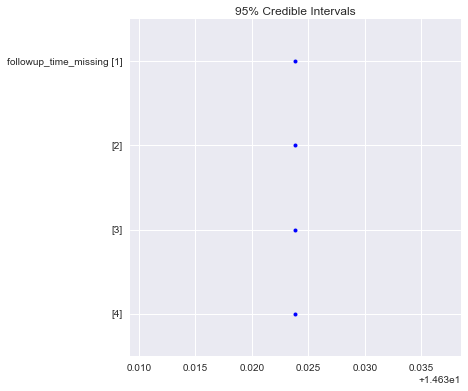

In [65]:
pm.forestplot(trace_uae, vars=['followup_time_missing'])

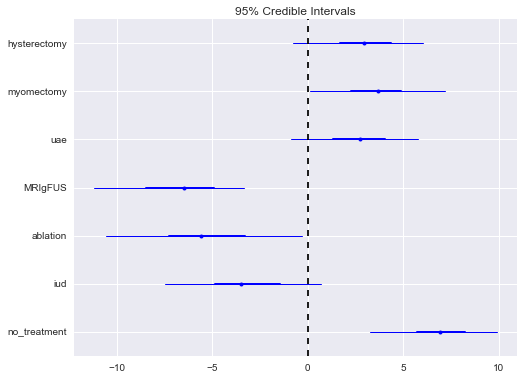

In [66]:
pm.forestplot(trace_uae, vars=['μ'], ylabels=plot_labels)

Follow-up time effect size estimates. Positive values indicate higher probability of event with increased follow-up time.

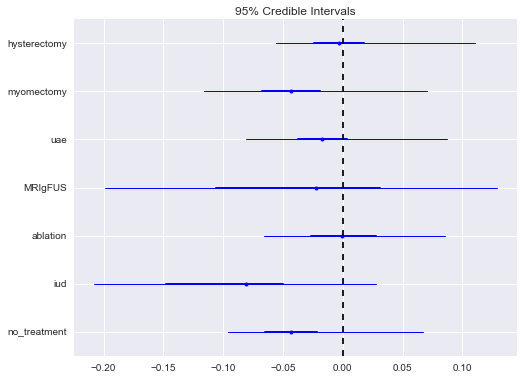

In [54]:
pm.forestplot(trace_uae, vars=['β_fup'], ylabels=plot_labels)

Age effect size estimates. Positive values suggest higher probability of event with each year above age 40.

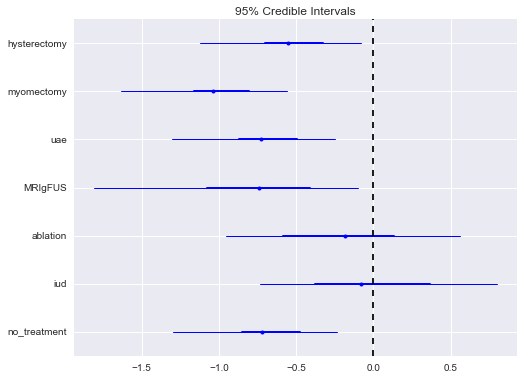

In [55]:
pm.forestplot(trace_uae, vars=['β_age'], ylabels=plot_labels)

Estimated probabilities of follow-up interventions for 6-month followup and age 40.

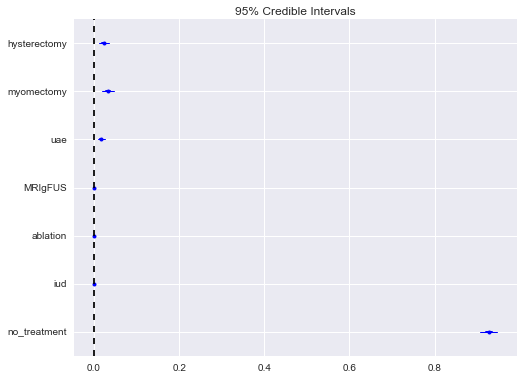

In [57]:
pm.forestplot(trace_uae, vars=['p_6'], ylabels=plot_labels)

In [58]:
pm.summary(trace_uae, vars=['p_6'])


p_6:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.023            0.007            0.000            [0.012, 0.034]
  0.033            0.007            0.000            [0.020, 0.048]
  0.016            0.004            0.000            [0.009, 0.025]
  0.000            0.002            0.000            [0.000, 0.001]
  0.000            0.001            0.000            [0.000, 0.001]
  0.000            0.004            0.000            [0.000, 0.001]
  0.927            0.013            0.001            [0.907, 0.948]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.013          0.019          0.022          0.026          0.036
  0.020          0.027          0.032          0.037          0.048
  0.009          0.013          0.016          0.019          0.026
  0.000     

Estimated probabilities of follow-up interventions for 12-month followup and age 40.

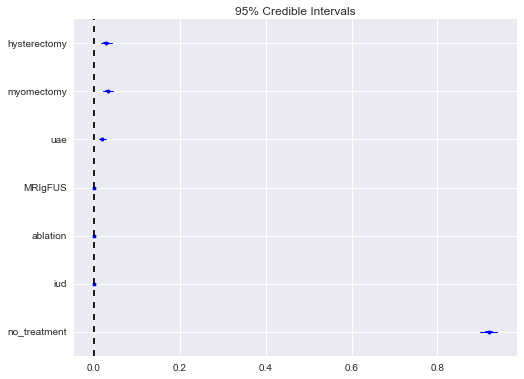

In [59]:
pm.forestplot(trace_uae, vars=['p_12'], ylabels=plot_labels)

In [60]:
pm.summary(trace_uae, vars=['p_12'])


p_12:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.029            0.008            0.000            [0.015, 0.042]
  0.032            0.006            0.000            [0.020, 0.044]
  0.019            0.005            0.000            [0.010, 0.028]
  0.000            0.002            0.000            [0.000, 0.001]
  0.000            0.001            0.000            [0.000, 0.001]
  0.000            0.004            0.000            [0.000, 0.001]
  0.920            0.013            0.001            [0.899, 0.940]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.016          0.024          0.028          0.033          0.044
  0.021          0.027          0.031          0.036          0.045
  0.011          0.016          0.019          0.022          0.029
  0.000    

Estimated probabilities of follow-up interventions for 12-month followup and age 50.

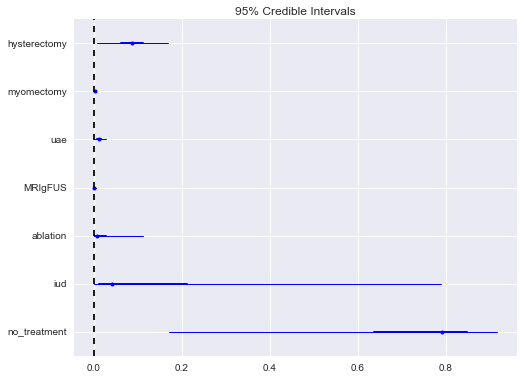

In [61]:
pm.forestplot(trace_uae, vars=['p_6_50'], ylabels=plot_labels)

In [62]:
pm.summary(trace_uae, vars=['p_6_50'])


p_6_50:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.089            0.043            0.003            [0.007, 0.168]
  0.001            0.002            0.000            [0.000, 0.002]
  0.012            0.007            0.000            [0.001, 0.026]
  0.001            0.003            0.000            [0.000, 0.005]
  0.025            0.048            0.004            [0.000, 0.111]
  0.173            0.255            0.024            [0.000, 0.788]
  0.699            0.219            0.020            [0.170, 0.917]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.014          0.061          0.085          0.112          0.185
  0.000          0.001          0.001          0.001          0.003
  0.002          0.007          0.011          0.016          0.030
  0.000  

In [45]:
med_manage_model = specify_model(med_manage_model, 'med_manage')

Applied log-transform to nu and added transformed nu_log to model.
Applied interval-transform to σ and added transformed σ_interval to model.


In [46]:
with med_manage_model:
        
    trace_med_manage = pm.sample(2000)

/Users/fonnescj/anaconda3/lib/python3.5/site-packages/theano/gradient.py:545: UserWarning: grad method was asked to compute the gradient with respect to a variable that is not part of the computational graph of the cost, or is used only by a non-differentiable operator: ϵ
  handle_disconnected(elem)
/Users/fonnescj/anaconda3/lib/python3.5/site-packages/theano/gradient.py:571: UserWarning: grad method was asked to compute the gradient with respect to a variable that is not part of the computational graph of the cost, or is used only by a non-differentiable operator: <DisconnectedType>
  handle_disconnected(rval[i])
/Users/fonnescj/anaconda3/lib/python3.5/site-packages/theano/gradient.py:545: UserWarning: grad method was asked to compute the gradient with respect to a variable that is not part of the computational graph of the cost, or is used only by a non-differentiable operator: ϵ
  handle_disconnected(elem)
/Users/fonnescj/anaconda3/lib/python3.5/site-packages/theano/gradient.py:571:

Assigned NUTS to followup_time_missing
Assigned NUTS to nu_log
Assigned NUTS to age_centered_missing
Assigned NUTS to μ
Assigned NUTS to β_fup
Assigned NUTS to β_age
Assigned NUTS to σ_interval
Assigned NUTS to ϵ
Assigned NUTS to followup_time_missing
Assigned NUTS to nu_log
Assigned NUTS to age_centered_missing
Assigned NUTS to μ
Assigned NUTS to β_fup
Assigned NUTS to β_age
Assigned NUTS to σ_interval
Assigned NUTS to ϵ


IndexError: index out of bounds

In [43]:
med_manage_model.vars

[followup_time_missing,
 nu_log,
 age_centered_missing,
 μ,
 β_fup,
 β_age,
 σ_interval,
 ϵ]

IndexError: index 0 is out of bounds for axis 0 with size 0

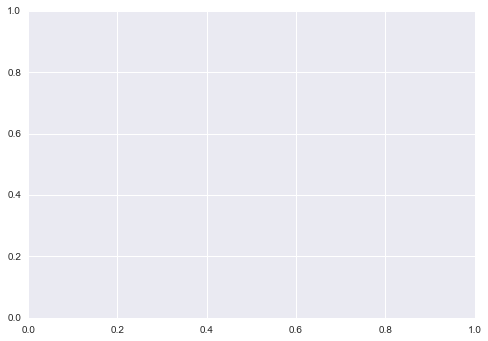

In [44]:
pm.forestplot(trace_med_manage, vars=['age_centered_missing'], ylabels=plot_labels)

In [40]:
pm.summary(trace_med_manage, vars=['p_6', 'p_12'])


p_6:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.075            0.000            0.000            [0.075, 0.075]
  0.075            0.000            0.000            [0.075, 0.075]
  0.075            0.000            0.000            [0.075, 0.075]
  0.075            0.000            0.000            [0.075, 0.075]
  0.075            0.000            0.000            [0.075, 0.075]
  0.075            0.000            0.000            [0.075, 0.075]
  0.552            0.000            0.000            [0.552, 0.552]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.075          0.075          0.075          0.075          0.075
  0.075          0.075          0.075          0.075          0.075
  0.075          0.075          0.075          0.075          0.075
  0.075     

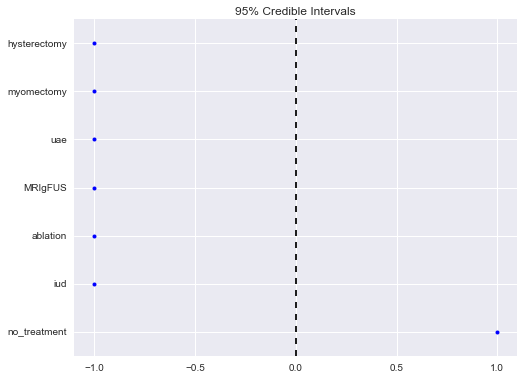

In [39]:
pm.forestplot(trace_med_manage, vars=['μ'], ylabels=plot_labels)

In [80]:
def get_data(intervention):
    
    intervention_data = dataset[(dataset.intervention_cat==intervention)
                            & ~dataset[outcome_cats].isnull().sum(axis=1).astype(bool)]
    
    followup_masked = masked_values(intervention_data.followup_interval.values, np.nan)
    followup_min, followup_max = intervention_data[['fup_min', 'fup_max']].values.T

    outcomes = intervention_data[[ 'hysterectomy', 'myomectomy', 'uae',
           'MRIgFUS', 'ablation', 'iud', 'no_treatment']].values
    
    if np.isnan(outcomes).any():
        print('Missing values in outcomes for', intervention)

    followup_n = intervention_data.followup_n.values

    # Center age at 40
    age_masked = masked_values(intervention_data['BL Mean'].values - 40, np.nan)
    
    studies = intervention_data.study_id.unique()
    study_index = np.array([np.argwhere(studies==i).squeeze() for i in intervention_data.study_id])

    study_id = intervention_data.study_id.values
    
    n_studies = len(set(study_id))

    n_outcomes = 7
    arms = len(outcomes)    
    intervention_data = dataset[(dataset.intervention_cat==intervention)
                            & ~dataset[outcome_cats].isnull().sum(axis=1).astype(bool)]
    
    followup_masked = masked_values(intervention_data.followup_interval.values, 17.33)
    followup_min, followup_max = intervention_data[['fup_min', 'fup_max']].values.T

    outcomes = intervention_data[[ 'hysterectomy', 'myomectomy', 'uae',
           'MRIgFUS', 'ablation', 'iud', 'no_treatment']].values

    followup_n = intervention_data.followup_n.values

    age_masked = masked_values(intervention_data['BL Mean'].values, 41.33)
    
    studies = intervention_data.study_id.unique()
    study_index = np.array([np.argwhere(studies==i).squeeze() for i in intervention_data.study_id])

    study_id = intervention_data.study_id.values
    
    n_studies = len(set(study_id))

    n_outcomes = 7
    arms = len(outcomes)
    
    return locals()

In [81]:
foo = get_data('med_manage')

In [84]:
foo['age_masked'] - 40

masked_array(data = [2.5 4.5 3.6000000000000014 -- 1.6000000000000014 1.6000000000000014
 1.1000000000000014 1.1000000000000014 -1 -1 -1 -0.3999999999999986
 -0.3999999999999986 -0.3999999999999986 1.6000000000000014
 1.6000000000000014 1.6000000000000014 1.6000000000000014
 1.6000000000000014 1.6000000000000014 1.6000000000000014
 1.6000000000000014 1.2999999999999972 1.2999999999999972
 1.2999999999999972 1.2999999999999972 1.1000000000000014
 1.1000000000000014 1.1000000000000014 1.1000000000000014
 -0.3299999999999983 -3.1300000000000026 -9.059999999999999 -9
 16.200000000000003 10.200000000000003 10.600000000000001
 -5.600000000000001 1 4 2.200000000000003 2.200000000000003 2 2 --
 9.200000000000003 -7.399999999999999 -- 9.200000000000003
 -7.399999999999999 -0.5 -1.8999999999999986 -3 -3 -- -- -- -- -- --],
             mask = [False False False  True False False False False False False False False
 False False False False False False False False False False False False
 False Fa